In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from PIL import Image
import torch

from sklearn.model_selection import train_test_split
from torchvision.datasets import KMNIST
import matplotlib.pyplot as plt

import time
import pandas as pd
from tqdm.notebook import tqdm_notebook
import random

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import cv2
from skimage.util import img_as_ubyte
from torchvision.models import VGG, vgg16

In [2]:
# Check if using GPU 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print(f"Nvidia Cuda/GPU is available!")

gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Nvidia Cuda/GPU is available!
Sun Apr 16 22:57:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   67C    P8    11W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                          

In [3]:
from google.colab import drive
drive.mount('/content/gdrive' )

Mounted at /content/gdrive


In [4]:
#Folder of the  drive is accessed
%cd '/content/gdrive/MyDrive/ecse551-mp3'

/content/gdrive/MyDrive/ecse551-mp3


Training data shape: (60000, 28, 28)
Training targets shape: (60000, 1)
Test data shape: (10000, 1, 28, 28)


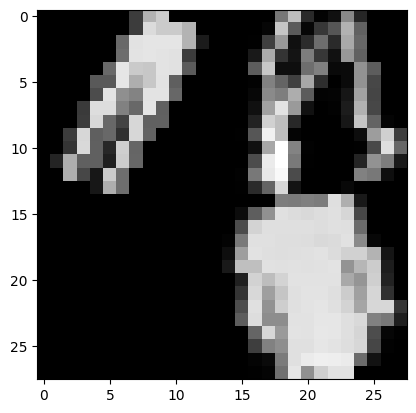

In [5]:
# Read a pickle file and disply its samples
# Note that image data are stored as unit8 so each element is an integer value between 0 and 255
train_data  = pickle.load( open( './Train.pkl', 'rb' ), encoding='bytes').reshape(-1,28,28) 
train_targets   = np.genfromtxt('./Train_labels.csv', delimiter=',', skip_header=1)[:,1:]
test_data  = pickle.load( open( './Test.pkl', 'rb' ), encoding='bytes')
plt.imshow(train_data[0,:,:].squeeze(),cmap='gray')

print('Training data shape:', train_data.shape)
print('Training targets shape:', train_targets.shape)
print('Test data shape:', test_data.shape)

#Dataset class
#Dataloader class

In [6]:
#Compute training data's mean and standard deviation
#Divide by 255 to scale grayscale values (0-255) to 0-1 range for neural network input

train_data = np.random.random((100, 100)) # Example data

mean_val = np.mean(train_data) / 255 # Compute the mean of the pixel values
std_val = np.std(train_data) / 255 # Compute the standard deviation of the pixel values

print(f"Mean: {mean_val}, Standard Deviation: {std_val}")

Mean: 0.001961744867166121, Standard Deviation: 0.0011254305365648407


**img_transform preprocessing**

In [7]:
# Transforms are common image transformations. They can be chained together using Compose.
''' 
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=5), ### hyperparameter "degrees" ###
])
'''
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=5), ### hyperparameter "degrees" ###
    transforms.Normalize([mean_val], [std_val]) ### hyperparameters "mean" and "std" ###
])
'''
img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomAffine(degrees=5), ### hyperparameter "degrees" ###
    transforms.Normalize(0.5, 0.5) ### hyperparameters "mean" and "std" ###
])
'''

' Doesnt work\nimg_transform = transforms.Compose([\n    transforms.ToTensor(),\n    transforms.RandomAffine(degrees=5), ### hyperparameter "degrees" ###\n    transforms.Normalize(0.5, 0.5) ### hyperparameters "mean" and "std" ###\n])\n'

In [8]:
class CustomDatasetTrain(Dataset):
  def __init__(self, image_file, label_file, data_transform=None, idx = None): 
    self.image_data = pickle.load( open( image_file, 'rb' ), encoding='bytes') # load the image data                     
    self.label_data = np.genfromtxt(label_file, delimiter=',', skip_header=1)[:,1:] # skip the first row
    self.data_transform = data_transform
    
    if idx is not None:
      self.label_data = self.label_data[idx] # select the idx-th row
      self.image_data = self.image_data[idx] # select the idx-th row

  def __len__(self):
    return len(self.label_data) # return the number of samples

  def __getitem__(self, idx):
    image, label = self.image_data[idx], int(self.label_data[idx]) # get the idx-th sample

    if self.data_transform is not None: # if there is a transform given, apply this transform to the image
      image = image.reshape(28,28) # reshape the image to 28x28
      image = Image.fromarray(image.astype('float'), mode='1') # convert the image to PIL image, mode='1' means the image is binary                  
      image = self.data_transform(image) # apply the transform to the image

    return image, label


In [9]:
class CustomDatasetTest(Dataset):
    
    def __init__(self, img_path, transform=None, indices=None):
        self.images = pickle.load(open(img_path, 'rb'))

        if indices is not None:
            self.images = self.images[indices]

        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, index):
        image = self.images[index]
        image = Image.fromarray(image.astype('uint8'), mode='L')

        if self.transform is not None:
            image = self.transform(image)

        return image


In [10]:
## ---- Load data for entire training set ---- ##
# Read image data and their label into a Dataset object #

## Note:- Selecting approximately 1000 test data from the set of 60000 as well. 

training_dataset = CustomDatasetTrain('./Train.pkl', './Train_labels.csv', idx=None)

# Load data using DataLoader
batch_size = 32                                                             # Set batch size based on the size of the training or test data
training_data = DataLoader(training_dataset, batch_size=batch_size, shuffle=True)  

torch.Size([32, 1, 28, 28])


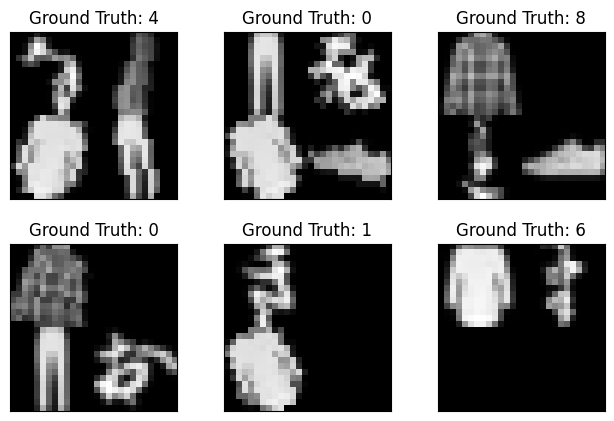

In [11]:
data = enumerate(training_data)
idx, (inputs, targets) = next(data)
print(inputs.shape)

fig = plt.figure()
for i in range(6):
  plt.subplot(2, 3, i+1)
  plt.tight_layout()
  plt.imshow(inputs[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(targets[i]))
  plt.xticks([])
  plt.yticks([])
fig.show()


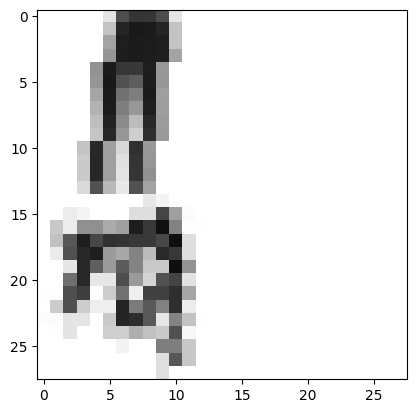

In [12]:
# Read a batch of data and their labels and display them
data_batch, target_labels = next(iter(training_data))
image = np.squeeze(data_batch)
plt.imshow(image[1].reshape(28, 28).cpu().numpy(), cmap='binary', vmin=0, vmax=1)

In [13]:
# Load test data
test_file = 'Test.pkl'
test_batch_size = 32

# Load test data using pickle
with open(test_file, 'rb') as file:
    test_data = DataLoader(pickle.load(file, encoding='bytes'), batch_size=test_batch_size)


In [14]:
# Shape when dataloader is used.
print(data_batch.shape)
print(target_labels.shape)

torch.Size([32, 1, 28, 28])
torch.Size([32])


#ResNet - CNN

In [15]:
import torch.nn as nn
import torch.optim as optim
from torchvision.models.resnet import ResNet, BasicBlock, Bottleneck

# ---- Modified ResNet 18 ----- #
class ModifiedResNet(ResNet):
    def __init__(self):
        super(ModifiedResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)

model_resnet = ModifiedResNet()

adam_optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)
loss_criterion = nn.CrossEntropyLoss()


#Training and Testing on ResNet

In [16]:
# Define dropout probability
dropout_prob = 0.2

# Clone ResNet model
num_ft = model_resnet.fc.in_features

# Replace fully connected layer with a new one with dropout
new_fc = nn.Sequential(nn.Dropout(p=dropout_prob), nn.Linear(num_ft, 10))
model_resnet.fc = new_fc

# Move the model to GPU
model_resnet.to('cuda')


ModifiedResNet(
  (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=

ResNet Model - Training & Validation

In [17]:

# Load training data and labels
train_data_source = CustomDatasetTrain('./Train.pkl', './Train_labels.csv', idx=None) # Load training data and labels

# Define sizes of training and validation sets
training_portion = int(0.8 * len(train_data_source)) # 80% of the data is used for training
validation_portion = len(train_data_source) - training_portion # 20% of the data is used for validation

# Split data into training and validation sets, using random_split
train_subset, validation_subset = torch.utils.data.random_split(train_data_source, [training_portion, validation_portion])

# Load data using DataLoader
data_batch_size = 100
train_loader = DataLoader(train_subset, batch_size=data_batch_size, shuffle=True) 
validation_loader = DataLoader(validation_subset, batch_size=data_batch_size, shuffle=True) 

## ----- Training Function for the ResNet ----- ##

def resnet_training(epoch, train_loader):
  model_resnet.train() # Set the model to training mode
  correct_predictions = 0 # Initialize the number of correct predictions
  total_predictions = 0 # Initialize the number of total predictions
  for idx, (data, label) in enumerate(train_loader): # Iterate over the training data
    data, label = data.cuda(), label.cuda() # Move the data and labels to the GPU
    adam_optimizer.zero_grad() # Clear the gradients
    model_output = model_resnet(data).cuda() # Forward pass
    _, prediction = torch.max(model_output.data, 1) # Get the predictions

    correct_predictions += (prediction == label).sum().item() # Update the number of correct predictions
    loss = loss_criterion(model_output, label) # Calculate the loss           
    total_predictions += label.size(0) # Update the number of total predictions
    accuracy_pct = (correct_predictions / total_predictions) * 100.0 # Calculate the accuracy
    progress_visual.set_description(f"Loss : {loss.item():.3f}, Training Accuracy : {accuracy_pct:.3f}") # Update the progress bar

    loss.backward() # Backward pass
    adam_optimizer.step() # Update the weights

  print(f'Epoch : {epoch}; Training Accuracy: {accuracy_pct:.3f}') # Print the training accuracy

## ----- Validation Function for the ResNet ----- ##

def resnet_validatation(epoch, validation_loader): # Validation function
  correct_predictions = 0 # Initialize the number of correct predictions
  total_predictions = 0 # Initialize the number of total predictions
  highest_accuracy = 0 # Initialize the highest accuracy
  for idx, (data, label) in enumerate(validation_loader): # Iterate over the validation data
    data, label = data.cuda(), label.cuda() # Move the data and labels to the GPU
    model_output = model_resnet(data).cuda() # Forward pass
    _, prediction = torch.max(model_output.data, 1) # Get the predictions
    correct_predictions += (prediction == label).sum().item() # Update the number of correct predictions
    total_predictions += label.size(0) # Update the number of total predictions
    accuracy_pct = (correct_predictions / total_predictions) * 100.0 # Calculate the accuracy
    progress_visual.set_description(f"Validation Accuracy : {accuracy_pct:.3f}") # Update the progress bar

    if accuracy_pct > highest_accuracy: 
      highest_accuracy = accuracy_pct

  print(f'Epoch : {epoch}; Validation Accuracy: {accuracy_pct:.3f}')
  return highest_accuracy


## ----- Running the epochs of ResNet ----- ##

iteration_count = 5 # Set the number of iterations to run
best_epoch = 0
progress_visual = tqdm_notebook(iterable=range(iteration_count), position=0, leave=True)
highest_accuracy = 0
begin_time = time.time()

for idx in progress_visual: # Iterate over the number of iterations
  resnet_training(idx + 1, train_loader) # Run the training function
  curr_val_acc = resnet_validatation(idx + 1, validation_loader) # Get the current validation accuracy
  if curr_val_acc > highest_accuracy: # Check if the current validation accuracy is higher than the highest accuracy
    highest_accuracy = curr_val_acc # Store the highest accuracy
    best_epoch = idx # Store the epoch with the highest accuracy
    torch.save(model_resnet.state_dict(), '/model.pth') # Save the model
    torch.save(adam_optimizer.state_dict(), '/optimizer.pth') # Save the optimizer

finish_time = time.time() # Get the time when the training is finished


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch : 1; Training Accuracy: 72.785
Epoch : 1; Validation Accuracy: 86.208
Epoch : 2; Training Accuracy: 89.385
Epoch : 2; Validation Accuracy: 90.250
Epoch : 3; Training Accuracy: 92.721
Epoch : 3; Validation Accuracy: 91.758
Epoch : 4; Training Accuracy: 94.833
Epoch : 4; Validation Accuracy: 92.475
Epoch : 5; Training Accuracy: 95.975
Epoch : 5; Validation Accuracy: 93.542


#Test and Save data

In [18]:
test_loader_final = test_data # This is the test data loader
predictions = []

def make_prediction(test_data=test_data):
    # Set the model to evaluation mode
    model_resnet.eval()

    test_loss = 0
    correct_count = 0

    with torch.no_grad():
        for single_data in test_data: 
            # Transfer data to the device (CPU or GPU)
            single_data = single_data.to(device)

            model_output = model_resnet(single_data)
            prediction = model_output.data.max(1, keepdim=True)[1]
            predictions.append(prediction.tolist())

    flattened_predictions = [item for sublist in predictions for item in sublist] # Flatten the list, since the predictions are in a list of lists
    final_predictions = [item for sublist in flattened_predictions for item in sublist] # Flatten the list, since the predictions are in a list of lists
    return final_predictions

def save_csv(predicted_data, output_file_name): # Save the predictions to a csv file
    formatted_data = {'id': np.arange(10000), 'class': predicted_data} # Create a dictionary with the data
    df = pd.DataFrame(formatted_data, columns=['id', 'class']) # Create a pandas dataframe with the data
    df.to_csv(output_file_name, index=False, header=True) # Save the dataframe to a csv file
    print("Data saved successfully! Check file name submit.csv") # Print a message to the user


In [19]:
# Record the start time of the program, make predictions, and record the end time 
start_time = time.time()
predictions_made = make_prediction(test_data=test_data) # Make predictions on the test set

print(f"Execution Time: {time.time() - start_time:.2f} seconds") # Print the execution time

save_csv(predictions_made, "submit.csv") # Save the predictions to a csv file

Execution Time: 1.30 seconds
Data saved successfully! Check file name submit.csv


# **Other training and validation codes, including ResNet 18 loss graph, ResNet 34, leakyReLU (with SGD optimizer) layers and VGG 16**

**ResNet 18 loss graph:**

In [20]:
'''
#showing loss in graph fo report 


sequence = list(range(0, 10000, 1)) # Create a sequence of numbers from 0 to 10000
batch_size = 32 # Set the batch size
grouped_sequence = [sequence[i:i + batch_size] for i in range(0, len(sequence), batch_size)] # Group the sequence into batches of size 32

test_idx = [i * len(training_data.dataset) for i in range(3)] # Create a list of indices to sample from the test set
peak_accuracy = 0 # Initialize peak accuracy to zero
average_accuracy = 0 # Initialize average accuracy to zero

num_iterations = 5 # Setting the number of epochs to run
progress_indicator = tqdm_notebook(iterable=range(num_iterations), position=0, leave=True) # Create a progress indicator

init_time = time.time() # Record the time at the start of training

loss_history = [] # Create an empty list to store training losses after each epoch

for current_epoch in progress_indicator: # Loop over the number of epochs
  model_resnet.train() # Set the model to training mode
  correct_predictions = 0 # Initialize correct predictions to zero
  total_predictions = 0 # Initialize total predictions to zero
  epoch_losses = 0 # Initialize epoch loss to zero 
  for batch_idx, (data_points, labels) in enumerate(training_data): # Loop over the training data
    data_points, labels = data_points.cuda(), labels.cuda() # Move data to GPU
    adam_optimizer.zero_grad() # Clear the gradients
    model_output = model_resnet(data_points).cuda() # Forward pass
    _, predicted_labels = torch.max(model_output, 1) # Get the predicted labels
    correct_predictions += (predicted_labels == labels).sum().item() # Update the number of correct predictions
    batch_loss = loss_criterion(model_output, labels) # Compute the loss
    total_predictions += labels.size(0) # Update the total number of predictions
    accuracy_pct = (correct_predictions / total_predictions) * 100.0 # Compute the accuracy
    progress_indicator.set_description(f"Loss : {batch_loss.item():.3f}, Main Data Accuracy : {accuracy_pct:.3f}") # Update the progress indicator
    epoch_losses += batch_loss.item() # Add batch loss to epoch loss 
    batch_loss.backward() # Backpropagate the loss
    adam_optimizer.step() # Update the model parameters

  loss_history.append(epoch_losses / len(training_data))  # Save average training loss after each epoch

  print(f'Epoch : {current_epoch + 1} ; Training Loss on main data: {epoch_losses / len(training_data):.3f}') # Print the training loss after each epoch


plt.plot(range(1, num_iterations + 1), loss_history) # Plot the training loss vs epoch
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss vs Epoch')
plt.show()
'''

'\n#showing loss in graph fo report \n\n\nsequence = list(range(0, 10000, 1)) # Create a sequence of numbers from 0 to 10000\nbatch_size = 32 # Set the batch size\ngrouped_sequence = [sequence[i:i + batch_size] for i in range(0, len(sequence), batch_size)] # Group the sequence into batches of size 32\n\ntest_idx = [i * len(training_data.dataset) for i in range(3)] # Create a list of indices to sample from the test set\npeak_accuracy = 0 # Initialize peak accuracy to zero\naverage_accuracy = 0 # Initialize average accuracy to zero\n\nnum_iterations = 5 # Setting the number of epochs to run\nprogress_indicator = tqdm_notebook(iterable=range(num_iterations), position=0, leave=True) # Create a progress indicator\n\ninit_time = time.time() # Record the time at the start of training\n\nloss_history = [] # Create an empty list to store training losses after each epoch\n\nfor current_epoch in progress_indicator: # Loop over the number of epochs\n  model_resnet.train() # Set the model to traini

**ResNet 34 CNN model**

In [21]:
'''
class CustomResNet34(ResNet):
  def __init__(self):
    super(CustomResNet, self).init(BasicBlock, [3, 4, 6, 3], num_classes=10)
    self.initial_conv = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)
'''

'\nclass CustomResNet34(ResNet):\n  def __init__(self):\n    super(CustomResNet, self).init(BasicBlock, [3, 4, 6, 3], num_classes=10)\n    self.initial_conv = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)\n'

**LeakyReLU & SGD optimizer**

In [22]:
''' ignore to try leakyRelu
# ---- Modified ResNet 18 ----- #
class ModifiedResNet(ResNet):
    def __init__(self):
        super(ModifiedResNet, self).__init__(BasicBlock, [2, 2, 2, 2], num_classes=10)
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)

model_resnet = ModifiedResNet()

adam_optimizer = optim.Adam(model_resnet.parameters(), lr=0.001)
loss_criterion = nn.CrossEntropyLoss()
'''
''' Ignored for leakyRelu
# Define dropout probability
dropout_prob = 0.2

# Clone ResNet model
num_ft = model_resnet.fc.in_features

# Replace fully connected layer with a new one with dropout
new_fc = nn.Sequential(nn.Dropout(p=dropout_prob), nn.Linear(num_ft, 10))
model_resnet.fc = new_fc

# Move the model to GPU
model_resnet.to('cuda')
'''

" Ignored for leakyRelu\n# Define dropout probability\ndropout_prob = 0.2\n\n# Clone ResNet model\nnum_ft = model_resnet.fc.in_features\n\n# Replace fully connected layer with a new one with dropout\nnew_fc = nn.Sequential(nn.Dropout(p=dropout_prob), nn.Linear(num_ft, 10))\nmodel_resnet.fc = new_fc\n\n# Move the model to GPU\nmodel_resnet.to('cuda')\n"

In [23]:
''' Leaky ReLU
from torch.nn import LeakyReLU
class LeakyBasicBlock(BasicBlock):
    def __init__(self, *args, **kwargs):
        super(LeakyBasicBlock, self).__init__(*args, **kwargs)
        self.relu = LeakyReLU(negative_slope=0.01, inplace=True)

# ---- LeakyRELU ----- #
class MFResNetLeaky(ResNet):
    def __init__(self):
        super(MFResNetLeaky, self).__init__(LeakyBasicBlock, [2, 2, 2, 2], num_classes=10) # Based on ResNet18
        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)

model_resnet = MFResNetLeaky()

#Create separate optimizers and criteria for Resnet
adam_optimizer = optim.Adam(model_resnet.parameters(), lr=0.001) #adam optimizer
#SGD_optimizer = optim.SGD(model_resnet.parameters(), lr=0.01, momentum=0.9) #SGD optimizer
loss_criterion = nn.CrossEntropyLoss()

num_ft = model_resnet.fc.in_features
model_resnet.fc = nn.Sequential(nn.Dropout(p=0.25), nn.Linear(num_ft, 10))
model_resnet = model_resnet.to('cuda')
'''

" Leaky ReLU\nfrom torch.nn import LeakyReLU\nclass LeakyBasicBlock(BasicBlock):\n    def __init__(self, *args, **kwargs):\n        super(LeakyBasicBlock, self).__init__(*args, **kwargs)\n        self.relu = LeakyReLU(negative_slope=0.01, inplace=True)\n\n# ---- LeakyRELU ----- #\nclass MFResNetLeaky(ResNet):\n    def __init__(self):\n        super(MFResNetLeaky, self).__init__(LeakyBasicBlock, [2, 2, 2, 2], num_classes=10) # Based on ResNet18\n        self.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=1, padding=3, bias=False)\n\nmodel_resnet = MFResNetLeaky()\n\n#Create separate optimizers and criteria for Resnet\nadam_optimizer = optim.Adam(model_resnet.parameters(), lr=0.001) #adam optimizer\n#SGD_optimizer = optim.SGD(model_resnet.parameters(), lr=0.01, momentum=0.9) #SGD optimizer\nloss_criterion = nn.CrossEntropyLoss()\n\nnum_ft = model_resnet.fc.in_features\nmodel_resnet.fc = nn.Sequential(nn.Dropout(p=0.25), nn.Linear(num_ft, 10))\nmodel_resnet = model_resnet.to('cuda')\n"

**VGG 16**

VGG 16 CNN model

In [24]:
'''
class ModifiedVGG16(VGG):
    def __init__(self, num_classes=10):
        features = vgg16(pretrained=False).features

        # Remove the first MaxPool2d layer and the last three Conv2d layers
        features = nn.Sequential(*list(features.children())[:-10])

        super(ModifiedVGG16, self).__init__(features)
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(4096, num_classes),
        )
        self.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)


vgg_model = ModifiedVGG16().cuda()

# Create separate optimizers and criteria for ModifiedVGG16
optimizer_vgg = optim.Adam(vgg_model.parameters(), lr=0.001)
criterion_vgg = nn.CrossEntropyLoss()
'''

'\nclass ModifiedVGG16(VGG):\n    def __init__(self, num_classes=10):\n        features = vgg16(pretrained=False).features\n\n        # Remove the first MaxPool2d layer and the last three Conv2d layers\n        features = nn.Sequential(*list(features.children())[:-10])\n\n        super(ModifiedVGG16, self).__init__(features)\n        self.classifier = nn.Sequential(\n            nn.Linear(512 * 7 * 7, 4096),\n            nn.ReLU(True),\n            nn.Dropout(),\n            nn.Linear(4096, 4096),\n            nn.ReLU(True),\n            nn.Dropout(),\n            nn.Linear(4096, num_classes),\n        )\n        self.features[0] = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1)\n\n\nvgg_model = ModifiedVGG16().cuda()\n\n# Create separate optimizers and criteria for ModifiedVGG16\noptimizer_vgg = optim.Adam(vgg_model.parameters(), lr=0.001)\ncriterion_vgg = nn.CrossEntropyLoss()\n'

VGG 16 optimizer & loss criterion

In [25]:
'''
optimizer_vgg_adam = optim.Adam(vgg_model.parameters(), lr=0.001)

loss_criterion_vgg = nn.CrossEntropyLoss()
'''

'\noptimizer_vgg_adam = optim.Adam(vgg_model.parameters(), lr=0.001)\n\nloss_criterion_vgg = nn.CrossEntropyLoss()\n'

Training of VGG 16 parallel to ResNet 18

In [26]:
'''
lst_unique = list(range(0, 10000, 1))
batch_size = 1000
lst_splits = [lst_unique[i:i + batch_size] for i in range(0, len(lst_unique), batch_size)]

test_counts = [i*len(training_data.dataset) for i in range(3)]
best_accuracy = 0
average_accuracy = 0

num_epochs = 5

progress_bar_resnet18 = tqdm_notebook(iterable=range(num_epochs), position=0, leave=True, desc="ResNet 18 Progress")
progress_bar_vgg16 = tqdm_notebook(iterable=range(num_epochs), position=0, leave=True, desc="VGG 16 Progress")

start_time = time.time()

lst_training_losses_resnet18 = [] # Create an empty list to store training losses after each epoch for ResNet 18
lst_training_losses_vgg16 = [] # Create an empty list to store training losses after each epoch for vgg16

for epoch in range(num_epochs):

  model_resnet.train()
  correct1 = 0
  total1 = 0
  correct2 = 0
  total2 = 0
  epoch_loss_1 = 0

  for batch_idx, (data, target) in enumerate(training_data):

    data, target = data.cuda(), target.cuda()
    adam_optimizer.zero_grad()
    output1 = model_resnet(data).cuda()
    _, predicted = torch.max(output1, 1)
    correct1 += (predicted == target).sum().item()
    loss1 = loss_criterion(output1, target)             
    total1 += target.size(0)
    acc1 = (correct1 / total1) * 100.0
    progress_bar_resnet18.set_description(f"Loss Model 1: {loss1.item():.3f}, Main Data Accuracy Model 1: {acc1:.3f}")
    progress_bar_resnet18.update()
    loss1.backward()
    adam_optimizer.step()

    lst_training_losses_resnet18.append(epoch_loss_1/len(training_data))    # Save training accuracy after each epoch


  # Train VGG16
  vgg_model.train()
  correct_2 = 0
  total_2 = 0
  epoch_loss_2 = 0
  for batch_idx, (data, target) in enumerate(training_data):
      data, target = data.cuda(), target.cuda()
      optimizer_vgg_adam.zero_grad()
      output_2 = vgg_model(data).cuda()
      _, predicted_2 = torch.max(output_2, 1)
      correct_2 += (predicted_2 == target).sum().item()
      loss_2 = loss_criterion(output_2, target)
      total_2 += target.size(0)
      acc_2 = (correct_2 / total_2) * 100.0
      progress_bar_vgg16.set_description(f"Loss Model 2: {loss_2.item():.3f}, Main Data Accuracy Model 2: {acc_2:.3f}")
      progress_bar_vgg16.update()
      loss_2.backward()
      optimizer_vgg_adam.step()

      lst_training_losses_vgg16.append(epoch_loss_2/len(training_data))    # Save training accuracy after each epoch


  torch.save(model_resnet.state_dict(), '/trained_model_1.pth')
  torch.save(adam_optimizer.state_dict(), '/trained_optimizer_1.pth')
  torch.save(vgg_model.state_dict(), '/trained_model_vgg16.pth')
  torch.save(optimizer_vgg.state_dict(), '/trained_optimizer_vgg16.pth')

# Close progress bars after the loop
progress_bar_resnet18.close()
progress_bar_vgg16.close()
'''

'\nlst_unique = list(range(0, 10000, 1))\nbatch_size = 1000\nlst_splits = [lst_unique[i:i + batch_size] for i in range(0, len(lst_unique), batch_size)]\n\ntest_counts = [i*len(training_data.dataset) for i in range(3)]\nbest_accuracy = 0\naverage_accuracy = 0\n\nnum_epochs = 5\n\nprogress_bar_resnet18 = tqdm_notebook(iterable=range(num_epochs), position=0, leave=True, desc="ResNet 18 Progress")\nprogress_bar_vgg16 = tqdm_notebook(iterable=range(num_epochs), position=0, leave=True, desc="VGG 16 Progress")\n\nstart_time = time.time()\n\nlst_training_losses_resnet18 = [] # Create an empty list to store training losses after each epoch for ResNet 18\nlst_training_losses_vgg16 = [] # Create an empty list to store training losses after each epoch for vgg16\n\nfor epoch in range(num_epochs):\n\n  model_resnet.train()\n  correct1 = 0\n  total1 = 0\n  correct2 = 0\n  total2 = 0\n  epoch_loss_1 = 0\n\n  for batch_idx, (data, target) in enumerate(training_data):\n\n    data, target = data.cuda(), 

VGG 16 Test Prediction (without the store_csv function)

In [27]:
'''
test_loader_final = test_data # This is the test data loader
y_pred_vgg = []

def pred_vgg16(testdata=test_data):
    # evaluation mode
    vgg_model.eval()

    test_loss = 0
    correct_count = 0
    y_pred_vgg = []
    
    with torch.no_grad():
        for single_data in testdata:
          # transfer data to cuda if available
          data = data.to(device)

          model_output = vgg_model(single_data)
          prediction = model_output.data.max(1, keepdim=True)[1]
          y_pred_vgg.append(prediction.tolist())

    flattened_predictions = [item for sublist in y_pred_vgg for item in sublist] # Flatten the list, since the predictions are in a list of lists
    final_predictions = [item for sublist in flattened_predictions for item in sublist] # Flatten the list, since the predictions are in a list of lists
    return final_predictions

startall = time.time()
y_pred_vgg16 = pred_vgg16(testdata=test_data)
'''

'\ntest_loader_final = test_data # This is the test data loader\ny_pred_vgg = []\n\ndef pred_vgg16(testdata=test_data):\n    # evaluation mode\n    vgg_model.eval()\n\n    test_loss = 0\n    correct_count = 0\n    y_pred_vgg = []\n    \n    with torch.no_grad():\n        for single_data in testdata:\n          # transfer data to cuda if available\n          data = data.to(device)\n\n          model_output = vgg_model(single_data)\n          prediction = model_output.data.max(1, keepdim=True)[1]\n          y_pred_vgg.append(prediction.tolist())\n\n    flattened_predictions = [item for sublist in y_pred_vgg for item in sublist] # Flatten the list, since the predictions are in a list of lists\n    final_predictions = [item for sublist in flattened_predictions for item in sublist] # Flatten the list, since the predictions are in a list of lists\n    return final_predictions\n\nstartall = time.time()\ny_pred_vgg16 = pred_vgg16(testdata=test_data)\n'